# Assignment 1 - Linear Algebra


In this exercise, you will investigate various aspects of linear algebra. You will study several different methods for solving simultaneous equations :
* matrix inversion using Cramer's rule
* LU decomposition
* SVD decomposition

The cell below contains the matrix inversion method based on Cramer's rule that you will have seen already in the Matrix Inversion notebook. You should use LU and SVD decomposition from SciPy.  See the Advanced Python Tutorial section 5.2.3, as well as the SciPy reference manual for further information :
https://docs.scipy.org/doc/scipy/reference/


In each part of this assignment, you will be asked to write some code in the cell indicated.  If you find it convenient to break your code up over multiple cells, please do so.  You will also be asked to briefly discuss your code and results obtained in a text cell.

You should use numpy and scipy libraries where appropriate. You will always be told explicitly if you should **not** use a particular library.  Make sure to comment your code.  Make sure all cells run from a freshly opened notebook before you submit your work.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 26 11:19:14 2020

@author: Peter Thomas
"""

import numpy as np
import math
import time
import timeit
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import MaxNLocator
import scipy
from scipy import linalg
from scipy.optimize import curve_fit

def det2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")
    
    return ( m[0][0]*m[1][1] ) - ( m[0][1]*m[1][0] )

def inverse2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")

    det = det2x2(m)
    tmp = np.empty([2,2])
    tmp[0][0] = m[1][1] / det
    tmp[0][1] = -1 * m[0][1] / det
    tmp[1][0] = -1 * m[1][0] / det
    tmp[1][1] = m[0][0] / det
    return tmp

def submatrix(m,i,j):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    # create a new matrix
    n = m.shape[0]-1
    tmp = np.empty([n,n])
    
    # get the indices of the matrix that will be used
    tmpi = list(range(m.shape[0]))
    del tmpi[i]
    tmpj = list(range(m.shape[1]))
    del tmpj[j]
    
    for ii in range(n):
        for jj in range(n):
            tmp[ii][jj] = m[tmpi[ii]][tmpj[jj]]

    return tmp

def det(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if (m.shape[0]==2):
        return det2x2(m)
        
    else:
        tmp = 0
        # use 0-th row to calculate determinant
        for j in range(m.shape[0]):
            tmp = tmp + (math.pow(-1,j) * m[0][j] * det(submatrix(m,0,j)))
    
    return tmp

def adj(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    tmp = np.empty(m.shape)
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            # note the order of indices below !
            tmp[j][i] = (math.pow(-1,i+j) * det(submatrix(m,i,j)))
    return tmp

def inverse(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if m.shape[0]==2:
        return inverse2x2(m)
    
    d = det(m)        
    c = adj(m)
    return np.true_divide(c,d)


## Part 1

Plot the cpu-time taken to solve a randomly generated simultaneous equation as a function of the matrix order N, for each of the methods mentioned in the introduction.

Note that you will need to :
* generate both a random real NxN matrix, and a random RHS of the matrix equation, using `numpy.random` (see Advanced Python Tutorial section 4.1).
* handle problems that cannot be solved, eg. if the random matrix is singular.
* make sure that your treatment of each routine is "fair", in that each one solves the same problem.

It will take some time to generate results for this part of the assignment.  It is strongly recommended that you test your code for a small range of N initially, eg $2 \leq N \leq 4$, before moving to higher N. **You do not need to generate results using the Cramer's rule method for $N \ge 5$.**, although for LU and SVD decomposition methods, you should be able to generate results for higher N.

It is also strongly recommended that you generate results in one cell, and then analyse them in a separate cell, so you do not have to re-generate results when changing plot styles, for example).

In [2]:
def SqMatrixGenArray(NStart,NEnd):
    """Creates a N square matrix for each integer value of N between an 
    inclusive defined range [NStart,NEnd] using a seeded random number 
    generator and places them in an array.
    """
    #global MatrixArray
    Seed = 12345 # seed is given to ensure that the same matrices are used when solving different methods
    SqMatrixArray = []
    
    
    if NStart == 1 or type(NStart) != int  or type(NEnd) != int :
        raise Exception ("Not a valid square matrix")
        
    for i in range(NStart,NEnd+1):
        np.random.seed(Seed)
        if linalg.det((np.random.randint(100, size=(i,i))), check_finite=False) == 0: # checks to see if matrix is singular.
            Seed += 1 #  will change the seed by +1 if it is Singular.
            print("Changing seed"+str(Seed))
        else:   
            
            SqMatrixArray.append(np.random.randint(100, size=(i,i))) # Non singular square matrix is added to array
                     
            Seed += 1
            
    return SqMatrixArray



def RHSMatrixGenArray(NStart,NEnd):
    """Creates one column matrices (of N rows) for each integer value of N 
    between an inclusive user defined range [NStart,NEnd] using a seeded random
    number generator and places them in an array.
    """
    #global RHSMatrixArray
    Seed = 1234
    RHSMatrixArray = []
    
    
    if NStart == 1 or type(NStart) != int  or type(NEnd) != int :
        raise Exception ("Not a valid square matrix")
        
    for i in range(NStart,NEnd+1):
        np.random.seed(Seed)
        
        RHSMatrixArray.append(np.random.randint(100, size=(i,1))) # Adds the matrix to the array of matrices.
      
        Seed += 1
 
    return RHSMatrixArray



def Solve_All(SqMatArray,RHSMatArray,method,n,PART_NUMBER,LargestN):
    """
        Simultaneous equation solving function, capable of Cramer, LU and SVD
        methods. This will solve an array of matrices and calculate the mean time 
        it takes to solve each method for each value of N in an NxN matrix.
          
    """
    global TTS , NValue

    SimSolution = [] # Simultaneous equation solutions, i.e these are the x matrices in a typical SE formula where Ax=y
    TTS = [] # Time To solve, this array holds the value of the mean time for the method when iterated n times.
    NValue = [] # Size of square matrix being solved, e.g 2 is a 2X2 matrix.
    if PART_NUMBER == 1:
        print("Solving Matrices... \n" +"N shaped matrix solved out of "+ str(LargestN)+"(For n = "+ str("{:.0e}".format(n))+"): ") # Used as a checkpoint for fault finding.
    elif PART_NUMBER == 2:
        print('Solving Matrices... \n')
    
    for i in range (len(SqMatArray)): #checks for each matrix in the array
       
        if method == 'SVD': # For the Singular Value Decomposition method (SVD).  
            StartTime = time.process_time() # Logs the time before solving the SE before n iterations
            
            for j in range(n): # Iterates the solving method n times
                U, s, Vh = linalg.svd(SqMatArray[i])  # This is the SVD.
                Sigma = np.diag(s) #Converts sigma values into a diagonal matrix.
                Solutions = ((Vh.T)@linalg.inv(Sigma)@(U.T)@RHSMatArray[i]) # This solves the SE using the SVD, where U and Vh are unitary so their inverse is equivalent to their transpose. 
                      
        elif method == 'LU': # For the LU Decomposition method (LU).       
            StartTime = time.process_time()# Logs the time before solving the SE before n iterations
        
            for j in range(n):# Iterates the solving method n times
                LU, piv = linalg.lu_factor(SqMatArray[i],check_finite=False) # Where LU is the LU decomposition and piv is the Pivot indices representing the permutation matrix P
                Solutions = linalg.lu_solve((LU, piv), RHSMatArray[i],check_finite=False) # This solves the SE using the LU decomposition. It does not check for finite values as the matrix generator only gives finite values.
                  
        elif method == 'Cramer':# For the Cramer method.          
            StartTime = time.process_time() # Logs the time before solving the SE before n iterations
            
            for j in range(n): # Iterates the solving method n times
                
                Solutions = inverse(SqMatArray[i]) @ RHSMatArray[i] #This solves the SE using Cramers method.
                   
        SimSolution.append(Solutions) 
        EndTime = time.process_time()# Logs the end time solving the SE after n iterations
        NValue.append(SqMatArray[i].shape[0])
        if PART_NUMBER == 1:
            TTS.append((EndTime-StartTime)/n)
            print(str(SqMatArray[i].shape[0]), end=' \r') # Prints the shape (N) of the square matrix on screen on the same line when the respective SE has been solved. Used as a checkpoint/porgression indicator.
            
        else:  
            continue
        
    print("\nSolved all Matrices \n")# Used as a checkpoint for fault finding.  
    return SimSolution



def DisplayMatrix(mArray):
    """ Prints matrix array in a more pleasing format. i.e seperated neatly and without the label "array".
    
    """
    print(*mArray, sep='\n\n')
    



def Display_Matrices():
    """ Displays all the matrices created of the form A, x and y, for SE formula Ax=y,
    including the N, TTS and n values. Mainly used for testing purposes.
    """
    
    print("Square Matrices: \n")
    DisplayMatrix(Sq_M)
    
    print('\n'+method + ' Method')
    print("RHS Matrices: \n")
    DisplayMatrix(RHS_M)
    
    print('\n'+method + ' Method')     
    print("Solved Matrices: \n")
    DisplayMatrix(Solved_M)
    print("\n")


def Part1Function(SmallestN,LargestN,n,method):
    """Generates A, x and y matrices (Sq_M,Solved_M and RHS_M respectively) 
    for part 1, it also includes printed indicators for progress indication.
    These are created for the full range of matrix order (specified by 
    [SmallestN,LargestN]) and iterated n times. Solving for the method given
    in the functions argument.
    """
    global Sq_M, RHS_M, Solved_M, Nvalue, TTS
    
    print("\nCreating Matrices") # Used as a checkpoint for fault finding.
    Sq_M = SqMatrixGenArray(SmallestN,LargestN) # Saves all the (A) Matrices generated to a single variable for tidiness, for SE formula Ax=y
    RHS_M = RHSMatrixGenArray(SmallestN,LargestN) # Saves all the (y) Matrices generated to a single variable for tidiness, for SE formula Ax=y
    print("Matrices Created") # Used as a checkpoint for fault finding.

    print('\n'+method + ' Method: ') # Used to label and differentiate between printed values and progression indicators for each method.
    Solved_M = Solve_All(Sq_M,RHS_M,method,n,1,LargestN) # Saves all the (x) Matrices generated to a single variable for tidiness, for SE formula Ax=y
    
       
    
def plot(x,y,title,xaxislabel, yaxislabel,n,MinXlim,MaxXLim,Y_Fit_check):
    """This function plots a graph.
    """
    
    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel(xaxislabel)#Labels x axis.
    plt.ylabel(yaxislabel)#labels y axis.
    plt.grid(True) #adds grid to graph
    plt.title(title)#Labels title
    plt.plot(x[MinXlim-2:MaxXLim],  y[MinXlim-2:MaxXLim],label = 'n = ' + (str("{:.0e}".format(n))))
    if Y_Fit_check == 'Y':
        plt.plot(x[MinXlim-2:MaxXLim], Y_Fit[MinXlim-2:MaxXLim], '--', color ='blue', label ="optimized data/best fit")

    plt.gca().legend() # plots the legend
    ax.legend(loc='best') # places the legend where it doesnt obscure data.
    plt.show()
    
    
def CreateWrite(x,y,Filename):
    """Creates a file, names it, transposes 2 arrays and writes them to a file. The order in the file is the same as the order input into the function."""
    np.savetxt(Filename+".txt", np.transpose([x,y]) , newline='\r\n', ) 
    
def CreateWrite2(x,y1,y2,y3,Filename):
    """Creates a file, names it, transposes 4 arrays and writes them to a file. The order in the file is the same as the order input into the function."""
    np.savetxt(Filename+".txt", np.transpose([x,y1,y2,y3]) , newline='\r\n', ) 
    
def testExp(NValue_Cramer, a, b): 
    """ Test for an exponential fit"""
    return a*np.exp(b*NValue_Cramer) 
def testPoly2(NValue_SVD, a, b, c):
    """ Test for a second order polynomial fit"""
    return a*(NValue_SVD) + b*(NValue_SVD**2) + c
def testPoly5(NValue_LU, a, b, c,d,e,f):
    """ Test for a fifth order polynomial fit"""
    return a*(NValue_LU) + b*(NValue_LU**2) + c*(NValue_LU**3) + d*(NValue_LU**4) + e*(NValue_LU**5) + f

In [3]:
#CRAMER SETTINGS=============================================================
method = 'Cramer' # Used as a variable for Solve_All to make it solve only using the given method.
SmallestN_Cramer = 2 # Denotes the Smallest square matrix of N shape to be solved.
LargestN_Cramer = 5 # Denotes the Largest square matrix of N shape to be solved.
n_Cramer = int(1e3) # Denotes how many times to run the solving method.

start = timer()
Part1Function(SmallestN_Cramer,LargestN_Cramer,n_Cramer,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
NValue_Cramer = NValue
TTS_Cramer = TTS 



Creating Matrices
Matrices Created

Cramer Method: 
Solving Matrices... 
N shaped matrix solved out of 5(For n = 1e+03): 
5 
Solved all Matrices 

Real time to compute (s): 5.2848382


Coefficients for an exponential fit: 
a = 4.3756830676335733e-07
b = 1.8448816650211628


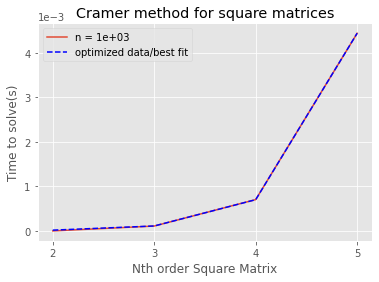

Part 1 Cramer plot 1


In [4]:
#CRAMER PLOT==================================================================
method = 'Cramer'
#Uncomment Display_Matrices to view all the matrices created.
#Display_Matrices()

#Uncomment CreateWrite to save the data to a text file labelled appropriately
#CreateWrite(NValue_Cramer,TTS_Cramer, str(method) + "Method_Part1_"+"n="+str("{:.0e}".format(n_Cramer))+"N=["+str(SmallestN_Cramer)+","+str(LargestN_Cramer)+"]")
Y_Fit = []
param, param_cov = curve_fit(testExp, NValue_Cramer, TTS_Cramer) #Generates variables for an exponential fit
for i in range (len(NValue_Cramer)):
    Y_Fit.append((param[0]*(np.exp(param[1]*NValue_Cramer[i])))) # Creates optimized curve of best fit, based on generated variables from curve_fit
print("Coefficients for an exponential fit: ")
print('a = ' +str(param[0]))
print('b = ' +str(param[1]))
Plot_Number = 1
with plt.style.context('ggplot'): #Styles the plot
    plot(NValue_Cramer,TTS_Cramer ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_Cramer,SmallestN_Cramer,LargestN_Cramer,'Y')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1

In [5]:
#LU SETTINGS=================================================================
method = 'LU' # Used as a variable for Solve_All to make it solve only using the given method.
SmallestN_LU = 2 # Denotes the Smallest square matrix of N shape to be solved.
LargestN_LU = 700 # Denotes the Largest square matrix of N shape to be solved.
n_LU = int(1e3) # Denotes how many times to run the solving method.

start = timer()
Part1Function(SmallestN_LU,LargestN_LU,n_LU,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
NValue_LU = NValue
TTS_LU = TTS 


Creating Matrices
Matrices Created

LU Method: 
Solving Matrices... 
N shaped matrix solved out of 700(For n = 1e+03): 
700                     
Solved all Matrices 

Real time to compute (s): 771.9174790999999


Coefficients for a 5th order polynomial fit:
a = 4.409790514543584e-06
b = -4.8007024848076355e-08
c = 5.053574851724068e-10
d = -1.0967828304506601e-12
e = 7.93359489632932e-16
f = -0.0001154775981385076


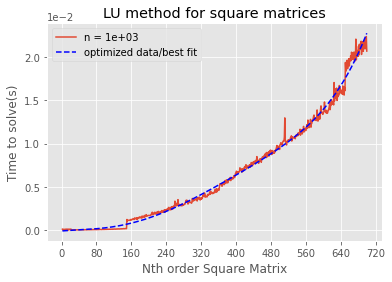

Part 1 LU plot 1


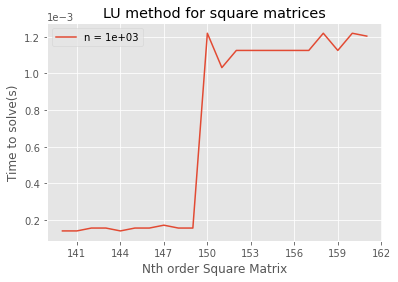

Part 1 LU plot 2


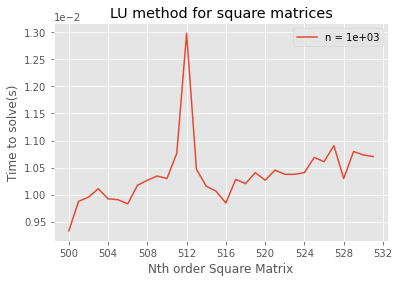

Part 1 LU plot 3


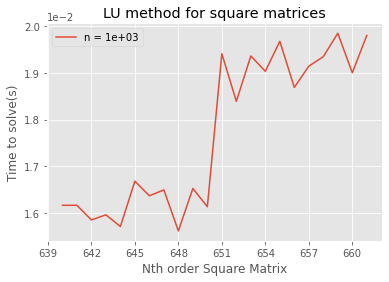

Part 1 LU plot 4


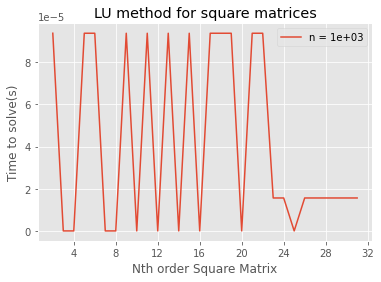

Part 1 LU plot 5


In [6]:
#LU PLOT========================================================================
method = 'LU'
#Uncomment Display_Matrices to view all the matrices created.
#Display_Matrices()

#Uncomment CreateWrite to save the plotting data to a text file
#CreateWrite(NValue_LU,TTS_LU, str(method) + "Method_Part1_"+"n="+str("{:.0e}".format(n_LU))+"N=["+str(SmallestN_LU)+","+str(LargestN_LU)+"]")
Y_Fit = []
param, param_cov = curve_fit(testPoly5, NValue_LU, TTS_LU) # Generates variables for an exponential fit
for i in range (len(NValue_LU)):
    Y_Fit.append(param[0]*(NValue_LU[i]) + param[1]*(NValue_LU[i]**2) + param[2]*(NValue_LU[i]**3) + param[3]*(NValue_LU[i]**4) + param[4]*(NValue_LU[i]**5) + param[5]) # Creates optimized curve of best fit, based on generated variables from curve_fit

print("Coefficients for a 5th order polynomial fit:")
print('a = ' +str(param[0]))
print('b = ' +str(param[1]))
print('c = ' +str(param[2]))
print('d = ' +str(param[3]))
print('e = ' +str(param[4]))
print('f = ' +str(param[5]))
Plot_Number = 1
with plt.style.context('ggplot'): #Styles the plot
    plot(NValue_LU,TTS_LU ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_LU,SmallestN_LU,LargestN_LU,'Y')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1
    plot(NValue_LU,TTS_LU ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_LU,140,160,'N')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1
    plot(NValue_LU,TTS_LU ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_LU,500,530,'N')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1
    plot(NValue_LU,TTS_LU ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_LU,640,660,'N')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1
    plot(NValue_LU,TTS_LU ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_LU,2,30,'N')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))

In [7]:
#SVD SETTINGS=================================================================
method = 'SVD' # Used as a variable for Solve_All to make it solve only using the given method.
SmallestN_SVD = 2 # Denotes the Smallest square matrix of N shape to be solved.
LargestN_SVD = 200 # Denotes the Largest square matrix of N shape to be solved.
n_SVD = int(1e3) # Denotes how many times to run the solving method.

start = timer()
Part1Function(SmallestN_SVD,LargestN_SVD,n_SVD,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
NValue_SVD = NValue
TTS_SVD = TTS 


Creating Matrices
Matrices Created

SVD Method: 
Solving Matrices... 
N shaped matrix solved out of 200(For n = 1e+03): 
200   
Solved all Matrices 

Real time to compute (s): 602.1746755


Coefficients for a 2nd order polynomial fit:
a = 7.679635940826022e-05
b = 2.063516791256326e-06
c = -0.0007587959916520988


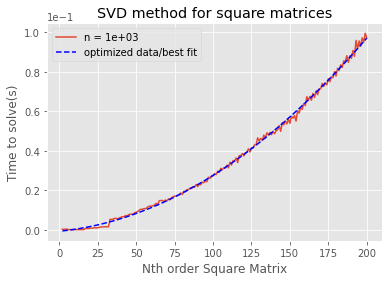

Part 1 SVD plot 1


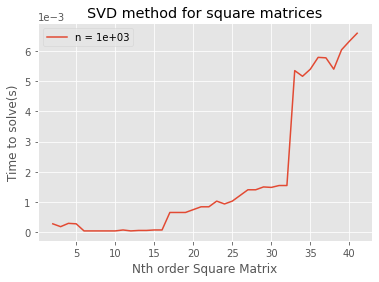

Part 1 SVD plot 2


In [8]:
#SVD PLOT=======================================================================
method = 'SVD'
#Uncomment Display_Matrices to view all the matrices created.
#Display_Matrices()

#Uncomment CreateWrite to save the plotting data to a text file
#CreateWrite(NValue_SVD,TTS_SVD, str(method) + "Method_Part1_"+"n="+str("{:.0e}".format(n_SVD))+"N=["+str(SmallestN_SVD)+","+str(LargestN_SVD)+"]")
Y_Fit = []
param, param_cov = curve_fit(testPoly2, NValue_SVD, TTS_SVD) # Generates variables for an exponential fit
for i in range (len(NValue_SVD)):
    Y_Fit.append(param[0]*(NValue_SVD[i]) + param[1]*(NValue_SVD[i]**2) + param[2]) # Creates optimized curve of best fit, based on generated variables from curve_fit

print("Coefficients for a 2nd order polynomial fit:")
print('a = ' +str(param[0]))
print('b = ' +str(param[1]))
print('c = ' +str(param[2]))
Plot_Number = 1
with plt.style.context('ggplot'): #Styles the plot
    plot(NValue_SVD,TTS_SVD ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_SVD,SmallestN_SVD,LargestN_SVD,'Y')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1
    plot(NValue_SVD,TTS_SVD ,str(method) + " method for square matrices","Nth order Square Matrix", "Time to solve(s)",n_SVD,2,40,'N')
    print("Part 1 " + str(method)+" plot " + str(Plot_Number))
    Plot_Number +=1

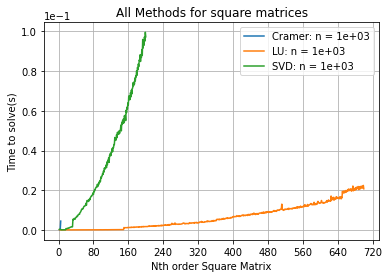

Part 1 All plot 1


In [9]:
#ALL PLOT ============================================================================
fig, ax = plt.subplots()
ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Nth order Square Matrix")#Labels x axis.
plt.ylabel("Time to solve(s)")#labels y axis.
plt.grid(True) #adds grid to graph
plt.title('All Methods for square matrices')#Labels title
plt.plot(NValue_Cramer[SmallestN_Cramer-2:LargestN_Cramer],  TTS_Cramer[SmallestN_Cramer-2:LargestN_Cramer],label = 'Cramer: n = ' + (str("{:.0e}".format(n_Cramer))))
plt.plot(NValue_LU[SmallestN_LU-2:LargestN_LU],  TTS_LU[SmallestN_LU-2:LargestN_LU],label = 'LU: n = ' + (str("{:.0e}".format(n_LU))))
plt.plot(NValue_SVD[SmallestN_SVD-2:LargestN_SVD],  TTS_SVD[SmallestN_SVD-2:LargestN_SVD],label = 'SVD: n = ' + (str("{:.0e}".format(n_SVD))))
#plt.gca().legend() # plots the legend
ax.legend(loc='best') # places the legend where it doesnt obscure data.
plt.show()
print("Part 1 All plot 1")


1. How My code works/solves the problems mentioned above.

Simultaneous equations of the form Ax = y are solved.

‘A’ is referred to as the Square Matrix, ‘x’  as the Solutions Matrix and ‘y’ Right Hand Side Matrix (RHS).

The function SqMatrixGenRHSArray creates a square matrix (A) for each order of N specified (where N is the order of an NxN matrix, i.e N = 2 for a 2X2 matrix). It does this by using a seed to produce an Nth order matrix of random integers between 0 - 100. By doing so this ensures that all methods will solve the same Nth order matrix. The range of 0 - 100 was chosen to ensure finite values were given – although it would work identically with a different finite range.

When creating the matrix it is checked to ensure it is not singular i.e its determinant is not zero. If it is zero, the seed is changed, and notification is printed to inform the user. It also checks to ensure the Nth order values requested are integer and if the starting order of N (NStart) is not equivalent to one. If any of these returns false, then an exception is ran with a message informing of the invalidity of the matrix.

Once an Nth order matrix is created it is placed within the array (SqMatrixArray) this is then returned when the function completes.

For the RHS Matrix (y) the process is similar except this time it creates an Nth order column matrix via the RHSMatrixGenArray function. This is then added to the RHSMatrixArray which is then returned when the function completes.

When it comes to the solution matrix (x), this is produced via the Solve_All function. This function will solve for Cramer, LU and SVD when specifying the method in its argument. All Nth orders of the solution matrix are saved to the array (Solved_M). It also computes the average time to compute each method by iterating the computation method n times, these values are saved to the TTS array.

SqMatrixGenRHSArray, RHSMatrixGenArray and Solve_All are all generated via the Part1Function to reduce space. 

Broken down per method:
Cramer method is used from the given Cramer functions as part of the assignment. This method finds the inverse matrix of A and computes a dot product between the inverse of A and y. This produces the solutions matrix ,‘x’.

LU method is used using Linalg from the Scipy library. By using linalg.lu_factor() it factorises the square matrix, A,  into its LU decomposition and pivot indices representing the permutation matrix, these values are then put through linalg.lu_solve() along with the RHS Matrix, y,  for each Nth order. Thereby computing the solutions matrix, x.

SVD Method  is used using Linalg from the Scipy library also. By using linalg.svd it produces the SVD, with matrices ‘U’ and ‘Vh’ and the singular values ‘s’, ‘s’ is then transformed into a diagonal matrix for the next step. The decomposition is then inverted for the dot production with the RHS matrix. Due to the Unitary nature of ‘U’ and ‘Vh’  the inverse is equivalent to its transpose. Therefore transposing ‘U’ and ‘Vh’ saves significant time when finding the solution matrix over directly inverting them.

After all the matrices have been calculated for a certain method the variables used for plotting (NValue, TTS) are saved to a specific variable for that method. This allows the user to edit and rerun the plotting cell and for it to use the correct values for that method. Otherwise you would be plotting the incorrect data.
Finally the plots are created and labelled according to the method used and the number of iterations completed. A choice to display the matrices and/or save the data to a text file is given, by uncommenting the respective functions in the plotting sections of the code.



2. Discussion:

Choices of values:

The values of n were chosen by considering two factors:  Observing only minor changes in trend between higher values of n and total time to run. Ultimately, the values of n chosen in testing were values that produced results that did not vary substantially from the previous run of the code at higher orders of n and which did not let the code run for too long. Here, a substantial variation means a significant change in graph shape, often becoming widely jagged due to the decrease in precision on the y value (Time to solve - on the plots) due to smaller number of iterations. 
Ranges of the order N were decided firstly on assignment parameters (i.e Cramer’s N value to be between 2 and 5), secondly by how long it would take to compute given the value of ‘n’ iterations needed for the desired precision and thirdly to ensure it accurately encapsulates the behaviour of the time taken to solve given the order N. 

For Cramer’s method, it approximately takes 5 seconds to create and solve the matrices of order N =  [2, 5],  each solution iterated n = 1000 times. Increasing n by an order of magnitude produces no significant change in plotted shape. The plot (figure: Part 1 Cramer plot 1) is clearly exponential in shape ($y = ae^{xb}$), and a curve fit is applied from the SciPy library to calculate the parameters of ‘a’ and ‘b’ for the exponential test from the function testExp. The plotted optimized data/best fit for an exponential test, perfectly aligns with the generated data on the same graph. With values of a and b are printed above the plots for the Cramer method. These values can be used to calculate time to solve for any order of N when combining with the exponential equation for the Cramer method.

For the LU method, it approximately takes 12 minutes to create and solve the matrices of order N = [2,700], each solution iterated n = 1000 times (figure: Part 1 LU plot 1) . At first it may seem like such a large range is unnecessary, but during analysis large changes in the graphs shape were observed – even at n = 1e6 - and therefore lowering n and increasing the order of N to fully encapsulate the trend was computed. In doing so there is a trade-off, a decrease in local precision for an increase in overall trend accuracy. The large jumps occur for N = 150, 512 and 651 (figures: Part 1 LU plot: 2, 3 and 4 respectively). For  N = 512 it is likely that this is just a particularly difficult matrix to solve for, as the TTS value returns to follow the previous trend immediately after – this can be checked by changing the seed value in the function SqMatrixGenArray(). However, this is not the case N = 150, 651 (due to the statistical impossibility of every successive matrix also being abnormally more difficult). In all honesty, I am quite surprised at the sudden jumps at these values. With the only hypothesis I can offer is that: at a certain size of matrix, its size (and therefore memory allocation) crosses some threshold in which it takes longer to call and/or manipulate. This is supported by the fact that the trend after these jumps seems to stabilise and not immediately return as seen for N= 512.  Therefore, whatever the issue/property concerning the memory for the LU decomposition of a matrix - say for a 150x150 matrix - is, this must also be the case for matrices larger than it.

The plot of N vs TTS (figure: Part 1 LU plot 1)  is not exponential but can be fitted relatively accurately with a 5th order polynomial fit ($y = ax +bx^{2} + cx^{3} + dx^{4} + ex^{5} + f $) tested with the function testPoly5 and applying the curve fit (from SciPy). The coefficients of the polynomial are printed above the LU plots and can be combined with the 5th order polynomial equation to predict time to solve values for any N when using the LU method.

For the SVD method, it approximately takes 8 minutes to create and solve the matrices of order N = [2,200] (figure: Part 1 SVD plot 1), each solution iterated n = 1000 times. In testing ranges of N were done up to N=500, however this takes a considerable amount of time (over an hour) to computer and the range N = [2,200] is more than enough to encapsulate the trend. For N = [7,35] (figure: Part 1 SVD plot 2), the trend is very linear with a large jump in time to solve occurring at N  = 36. After which the trend is accurately fitted with a second order polynomial fit ($y = ax +bx^{2} + c$), using the test function testPoly2 and a curve fit applied from the SciPy library. Values of the coefficients: a, b and c are printed above the graphs for the SVD method and can be used in conjunction with the second order polynomial to predict time to solve values for any N when using the SVD method.

Comparing all three methods:

Cramer’s method is clearly not a good method for solving simultaneous equations past the 3rd Nth order compared to the other two methods when considering the time to solve. Solving a 3x3 matrix in approximately the same time it takes the LU method to solve a 149x149 matrix. The SVD method does take roughly the same time to solve the matrices of order N =[2,5], but this then reduces and only when N = 35 does it take the same time to solve again. In figure: Part 1 All plot 1, all three methods are compared on the same plot. Here the differences in trends are most easily observed. Cramer’s method is the most stable although for such low rang of N it is not a very fair comparison. SVD compared to LU is much more stable in its trend, meaning that approximating time to solve with the second order polynomial used in the code would produce more accurate results. However, LU is consistently faster even if the local trends vary wildly at N = 150 and 651. In conclusion the LU method is not as precise as SVD for n=1000 but it is still much faster and should be the preferred method for non-singular square matrices.




**In this cell, briefly outline how your code solves the problems mentioned above, and discuss your results.**

## Part 2
Next, we will study the precision of the algorithms - in particular, for near singular matrices. Write a routine that will estimate (and plot) the accuracy of the result when solving the equation below, for small values of k. Your function should do this for all 3 routines in Part 1.

\begin{eqnarray*}
x + y + z & = & 5 \\
x + 2y - z & = & 10 \\
2x + 3y +kz & = & 15 
\end{eqnarray*}

You will need to choose a method to estimate the accuracy of the result, given that the equation solvers will return values for all of x, y, and z.  You should study a suitable range of values of k, to ensure that your results encapsulate the behaviour of each method. Some trial and error may be required to find a good range.

In [10]:
def SqMatrixGenArray_Part2(K_Smallest,K_Largest,nk):
    """Creates a 3X3 square matrix for each k value between an 
    inclusive defined range [K_Smallest,K_Largest] using nk as a the number of 
    steps between the range and places them in an array.
    """
    global K_Values
    SqMatrixArray = []
    K_Values = []
    for i in np.linspace(K_Smallest,K_Largest,num = nk):
        K_Values.append(i)
        
        SqMatrixArray.append(np.array([[1, 1, 1],[1, 2, -1],[2, 3, i]]))
            
    return SqMatrixArray
 


def Part2Function(K_Smallest,K_Largest,n,nk,method):
    """Generates A, x and y matrices (Sq_M,Solved_M and RHS_M respectively) 
    for part 2, it also includes printed indicators for progress indication.
    These are created for the full range of k values (specified by the number of nk steps in the range 
    [K_Smallest,K_Largest]) and iterated n times. Solving for the method given
    in the functions argument.
    """
    global Sq_M, RHS_M, Solved_M, Y_Diff_1stRow, Y_Diff_2ndRow,Y_Diff_3rdRow

    print ('Generating Matrices for ' + str(method) + ' Method... \n')
    Sq_M = SqMatrixGenArray_Part2(K_Smallest,K_Largest,nk)
    
    RHS_M = []
    RHSMatrix_Part_2 = np.array([[5],[10],[15]])
    for i in range(nk):
        RHS_M.append(RHSMatrix_Part_2)
 
    Solved_M = Solve_All(Sq_M,RHS_M,method,n,2,0) # Saves all the (x) Matrices generated to a single variable for tidiness, for SE formula Ax=y

    
    RHS_Calculated = []
    print('Calculating RHS Matrices for ' + str(method) + ' Method... \n')
    for i in range(nk):    
        RHS_Calculated.append(Sq_M[i]@Solved_M[i])
        
    print('Calculating percentage differences in y values for ' + str(method) + ' Method... \n')
    Y_Diff_1stRow = [] # Differences in 1st row values of the created RHS matrix and the calculated RHS matrix
    Y_Diff_2ndRow = [] # Differences in 2nd row values of the created RHS matrix and the calculated RHS matrix
    Y_Diff_3rdRow = [] # Differences in 3rd row values of the created RHS matrix and the calculated RHS matrix
    for i in range(nk):
        RHS_Diff = np.subtract(RHS_M[i],RHS_Calculated[i])
        Y_Diff_1stRow.append(abs(RHS_Diff[0]/RHSMatrix_Part_2[0])) # Calculates percentage difference
        Y_Diff_2ndRow.append(abs(RHS_Diff[1]/RHSMatrix_Part_2[1])) # Calculates percentage difference
        Y_Diff_3rdRow.append(abs(RHS_Diff[2]/RHSMatrix_Part_2[2])) # Calculates percentage difference

def plot3y(x,y1,y2,y3,title,xaxislabel, yaxislabel,nk_Smallest,nk_Largest):
    """This function plots a graph with three y values.
    """
    
    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    plt.xlabel(xaxislabel)#Labels x axis.
    plt.ylabel(yaxislabel)#labels y axis.
    plt.grid(True) #adds grid to graph
    plt.title(title)#Labels title
    plt.plot(x[nk_Smallest:nk_Largest],  y1[nk_Smallest:nk_Largest],label = 'y1')
    plt.plot(x[nk_Smallest:nk_Largest],  y2[nk_Smallest:nk_Largest],label = 'y2')
    plt.plot(x[nk_Smallest:nk_Largest],  y3[nk_Smallest:nk_Largest],label = 'y3')
    plt.gca().legend() # plots the legend
    ax.legend(loc='best') # places the legend where it doesnt obscure data.
    plt.show()
 

In [11]:
#CRAMERS SETTINGS=============================================================       
method = 'Cramer'
# Values are specified for each method to allowing replotting of a different method when done out of order.
K_Smallest_Cramer = 4e-16
K_Largest_Cramer = 4e-13
nk_Cramer= 10000 # Number of equidistant k values between range [K_Smallest,K_Largest]
n = 1

start = timer()
Part2Function(K_Smallest_Cramer,K_Largest_Cramer,n,nk_Cramer,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
# Values are renamed to allowing replotting of a different method when done out of order.
K_Values_Cramer = K_Values
Y_Diff_1stRow_Cramer = Y_Diff_1stRow
Y_Diff_2ndRow_Cramer = Y_Diff_2ndRow
Y_Diff_3rdRow_Cramer = Y_Diff_3rdRow

Generating Matrices for Cramer Method... 

Solving Matrices... 


Solved all Matrices 

Calculating RHS Matrices for Cramer Method... 

Calculating percentage differences in y values for Cramer Method... 

Real time to compute (s): 1.2273744000001443


Plotting graphs...


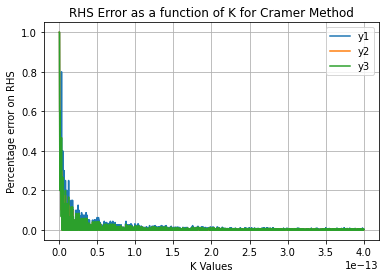

Part 2 Cramer plot 1
Graphs Plotted


In [12]:
#CRAMER PLOT=============================================================
method = 'Cramer'
print('Plotting graphs...')
plot3y(K_Values_Cramer,Y_Diff_1stRow_Cramer,Y_Diff_2ndRow_Cramer,Y_Diff_3rdRow_Cramer,'RHS Error as a function of K for ' + str(method) + ' Method', 'K Values', 'Percentage error on RHS',0,nk_Cramer)
Plot_Number = 1
print("Part 2 " + str(method)+" plot " + str(Plot_Number))
Plot_Number +=1
print('Graphs Plotted')

#Uncomment CreateWrite to save the data to a text file labelled appropriately
#CreateWrite2(K_Values_Cramer,Y_Diff_1stRow_Cramer,Y_Diff_2ndRow_Cramer,Y_Diff_3rdRow_Cramer, str(method) + "Method_Part2"+"_nk="+str("{:.0e}".format(nk_Cramer))+"K=["+str("{:.0e}".format(K_Smallest_Cramer))+","+str("{:.0e}".format(K_Largest_Cramer))+"]")

In [13]:
#LU SETTINGS=============================================================       
method = 'LU'
# Values are specified for each method to allowing replotting of a different method when done out of order.
K_Smallest_LU = 1.2e-16
K_Largest_LU = 1.2e-15
nk_LU= 10000 # Number of equidistant k values between range [K_Smallest,K_Largest]
n = 1

start = timer()
Part2Function(K_Smallest_LU,K_Largest_LU,n,nk_LU,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
# Values are renamed to allowing replotting of a different method when done out of order.
K_Values_LU = K_Values
Y_Diff_1stRow_LU = Y_Diff_1stRow
Y_Diff_2ndRow_LU = Y_Diff_2ndRow
Y_Diff_3rdRow_LU = Y_Diff_3rdRow

Generating Matrices for LU Method... 

Solving Matrices... 


Solved all Matrices 

Calculating RHS Matrices for LU Method... 

Calculating percentage differences in y values for LU Method... 

Real time to compute (s): 0.22359930000015993


Plotting graphs...



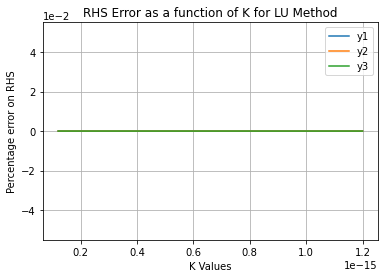

Part 2 LU plot 1
Graphs Plotted


In [14]:
#LU PLOT==================================================================
method = 'LU'
print('Plotting graphs...\n')
plot3y(K_Values_LU,Y_Diff_1stRow,Y_Diff_2ndRow_LU,Y_Diff_3rdRow_LU,'RHS Error as a function of K for ' + str(method) + ' Method', 'K Values', 'Percentage error on RHS',0,nk_LU)
Plot_Number = 1
print("Part 2 " + str(method)+" plot " + str(Plot_Number))
Plot_Number +=1
print('Graphs Plotted')

#Uncomment CreateWrite to save the data to a text file labelled appropriately
#CreateWrite2(K_Values_LU,Y_Diff_1stRow_LU,Y_Diff_2ndRow_LU,Y_Diff_3rdRow_LU, str(method) + "Method_Part2"+"_nk="+str("{:.0e}".format(nk_LU))+"K=["+str("{:.0e}".format(K_Smallest_LU))+","+str("{:.0e}".format(K_Largest_LU))+"]")

In [15]:
#SVD SETTINGS=============================================================       
method = 'SVD'
# Values are specified for each method to allowing replotting of a different method when done out of order.
K_Smallest_SVD = 3e-15
K_Largest_SVD = 3e-13
nk_SVD= 10000 # Number of equidistant k values between range [K_Smallest,K_Largest]
n = 1

start = timer()
Part2Function(K_Smallest_SVD,K_Largest_SVD,n,nk_SVD,method)
end = timer()
print("Real time to compute (s): "+ str(end - start))
# Values are renamed to allowing replotting of a different method when done out of order.
K_Values_SVD = K_Values
Y_Diff_1stRow_SVD = Y_Diff_1stRow
Y_Diff_2ndRow_SVD = Y_Diff_2ndRow
Y_Diff_3rdRow_SVD = Y_Diff_3rdRow

Generating Matrices for SVD Method... 

Solving Matrices... 


Solved all Matrices 

Calculating RHS Matrices for SVD Method... 

Calculating percentage differences in y values for SVD Method... 

Real time to compute (s): 0.5795352000000094


Plotting graphs...


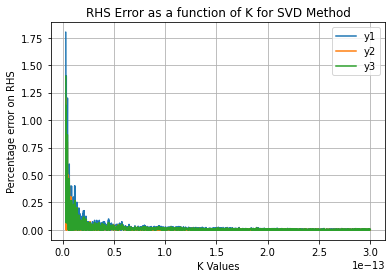

Part 2 SVD plot 1
Graphs Plotted


In [16]:
#SVD PLOT==================================================================
method = 'SVD'
print('Plotting graphs...')
plot3y(K_Values_SVD,Y_Diff_1stRow_SVD,Y_Diff_2ndRow_SVD,Y_Diff_3rdRow_SVD,'RHS Error as a function of K for ' + str(method) + ' Method', 'K Values', 'Percentage error on RHS',0,nk_SVD)  
Plot_Number = 1
print("Part 2 " + str(method)+" plot " + str(Plot_Number))
Plot_Number +=1
print('Graphs Plotted')

#Uncomment CreateWrite to save the data to a text file labelled appropriately
#CreateWrite2(K_Values_SVD,Y_Diff_1stRow_SVD,Y_Diff_2ndRow_SVD,Y_Diff_3rdRow_SVD, str(method) + "Method_Part2"+"_nk="+str("{:.0e}".format(nk_SVD))+"K=["+str("{:.0e}".format(K_Smallest_SVD))+","+str("{:.0e}".format(K_Largest_SVD))+"]")

**In this cell, briefly outline how your code solves the problems mentioned above, and discuss your results.**


1. How My code works/solves the problems mentioned above.
Simultaneous equations of the form Ax = y.

$x_{gen} = A^{-1}y_{given}$ 

$Ax_{gen} = y_{calc}$

$(y_{given} – y_{calc})\% = y_{Diff}$

In this section an array of 3x3 matrices are created with the same one value being changed. This value, k, is taken to small values approaching the machine epsilon - to produce near singular matrices. This section primarily creates, and computes results via the Part2Function. In this function the 3x3 matrices are created using the function SqMatrixGenArray_Part2() with nk number of k values between a range [K_Smallest,K_Largest] to produce the Sq_M array (A). It also creates an array of the RHS matrices (RHS_M) specified in the assignment. It then passes the Sq_M and RHS_M ($y_{given}$) in the Solve_All function to produce the solutions matrix array (Solved_M ($x_{gen}$). Until this point it is nearly identical to what is done in part 1, however now the dot products of Sq_M and Solved_M are added to the RHS_Calculated array ($y_{calc} $). Finally, the differences for each row in the RHS matrix are found by subtracting our original RHS matrix (RHS_M) with the recent RHS_Calculated for all the matrices created between the k range ($y_{Diff}$). These differences for each row are then converted to absolute percentage difference and added to their respective arrays i.e Y_Diff_1stRow, Y_Diff_2ndRow, Y_Diff_3rdRow. These values are then plotted on the same graph using plot3y().

2.Discussion

Choices of values:

The range of k was chosen by trial and error, going as small as I could without generating errors from trying to solve singular matrices, with the largest value chosen to encapsulate the trend.  The number of values of k between the range is given the name nk, and was given the value 10,000 for all three methods. This value is sufficient to clearly observe the trend in percentage error between the defined range.


For Cramer’s method it takes approximately 11 seconds to create and solve the Part2Function() for nk = 10,000 for k = [4e-16,4e-13]. By analysing figure Part 2 Cramer plot 1, the trend becomes exponential as the k value approaches 4e-13. With a maximum absolute error value around 1\%. When the k value is in the range [3e-16,4e-16), the method returns an error as it is unable to solve the singular matrix. 

For the LU method it takes approximately 0.2 seconds to create and solve the Part2Function() for nk = 10,000 for k = [1.2e-16, 1.2e-15]. By looking at figure: Part 2 LU plot 1, it is immediately apparent that the LU method produces zero error. This seems like it cannot be the case as the range chosen falls below the machine epsilon so we should still be able to observe an error even if its purely from the machine epsilon. Assuming my code is correct (does what I want it to do) and the method I have chosen is suitable, then the LU method (Linalg.lu_factor() and Linalg.lu_solve()) must have a way to factor in the machine epsilon when computing the results. Assuming this is correct then the LU method solves perfectly until its reaches a k value in the range [1.1e-16,1.2e-16), at which point it considers the matrix to be singular and produces an error.

For the SVD method it takes approximately 0.5 seconds to create and solve the Part2Function() for nk = 10,000 for k = [3e-15, 2e-13]. By looking at the figure: Part 2 SVD plot 1, the trend is exponential as the k value approaches 3e-15. A maximum error is found to be approximately 1.75\%. When the k value is in the range [2e-15, 3e-15), the method returns an error as it is unable to solve the singular matrix.  

Comparing all three method:

As the value of k gets smaller, it is expected for the absolute percentage error to increase exponentially due to the greater contribution in error from the machine epsilon (approx. 2.22e-16); this is evident in the Cramer and SVD method. The Cramer method can produce solutions that are not only more accurate than the SVD method but is also capable of solving for values of k that are nearly an order of magnitude smaller. This suggests that when solving a 3x3 matrix the Cramer method is superior to the SVD method in both accuracy and speed (see part 1 analysis). However, the LU method (from this analysis) is superior to both Cramer and SVD for accuracy and speed, as it produces no error and solves significantly faster.
